# Lab — Binary Classification and Logistic Models

In this first lab, we explore binary. We gradually move from simple Gaussian mixture models to logistic regression, polynomial feature expansion, ROC analysis, and finally a home-made implementation of logistic regression.

**Objectives:**
- Understand the Bayes classifier in the Gaussian mixture model.
- Implement and visualize the Bayes decision boundary.
- Build a Linear Discriminant Analysis (LDA) classifier.
- Compare LDA to logistic regression.
- Enrich logistic regression with polynomial features.
- Evaluate models using ROC curves and AUC.
- Implement logistic regression *from scratch* with gradient descent.


## 1. Gaussian Mixture and Bayes Classifier

We begin with a simple synthetic binary classification problem:
a **mixture of two Gaussians** with equal covariance matrix.  
In this setting, the **Bayes classifier** is known in closed form and is itself a *linear* classifier.

### Task
1. Implement a class that computes the Bayes decision rule.
2. Display the decision boundary, and experiment with several values of `p` and `rho` (correlation).

The function below will perform the plotting for you.


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def sigmoid(z): 
    return 1/(1+np.exp(-z))


class BayesClassifier:
    def __init__(self, p, mu0, mu1, rho):
        self.p = float(p)
        self.mu0 = np.asarray(mu0)
        self.mu1 = np.asarray(mu1)
        Sigma = np.array([[1, rho], [rho, 1]])
        S_inv = np.linalg.inv(Sigma)
        
        # direction vector
        self.w = S_inv @ (self.mu1 - self.mu0)# Your code here
        
        # bias term
        t1 = self.mu1 @ S_inv @ self.mu1
        t0 = self.mu0 @ S_inv @ self.mu0
        self.b = 0.5 * (t0 - t1) + np.log(self.p / (1 - self.p)) # Your code here

    def decision_function(self, X):
        """Return the linear score w^T x + b."""
        # Your code here
        return X @ self.w + self.b

    def predict_proba(self, X):
        s = self.decision_function(X)
        p1 = sigmoid(s)
        return np.c_[1 - p1, p1]

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)



In [17]:
def plot_mixture_and_bayes(p, mu0, mu1, rho):
    mu0, mu1 = map(np.asarray, (mu0, mu1))
    Sigma = np.array([[1, rho], [rho, 1]])
    clf = BayesClassifier(p, mu0, mu1, rho)

    # Grid (auto-sized if samples provided)
    x_min, x_max, y_min, y_max = -4, 4, -4, 4

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                         np.linspace(y_min, y_max, 300))
    G = np.c_[xx.ravel(), yy.ravel()]

    # Gaussian mixture
    f0 = multivariate_normal(mu0, Sigma).pdf(G)
    f1 = multivariate_normal(mu1, Sigma).pdf(G)
    Z = ((1-p)*f0 + p*f1).reshape(xx.shape)

    # Bayes boundary
    post = clf.predict_proba(G)[:,1].reshape(xx.shape)

    # Plot
    plt.figure(figsize=(7,6))
    plt.contourf(xx, yy, Z, levels=20, cmap="viridis")
    plt.contour(xx, yy, Z, colors="k", linewidths=0.4)
    plt.contour(xx, yy, post, levels=[0.5], colors=["#ff0000"], linewidths=2.5)
    
    plt.gca().set_aspect("equal")
    plt.title(f"Mixture level sets + Bayes boundary (p={p}, rho={rho})")
    plt.show()


### Example: Visualizing the Bayes classifier

We now visualize two scenarios:
- balanced and uncorrelated mixture,
- unbalanced and correlated mixture.

Observe how the Bayes boundary changes.


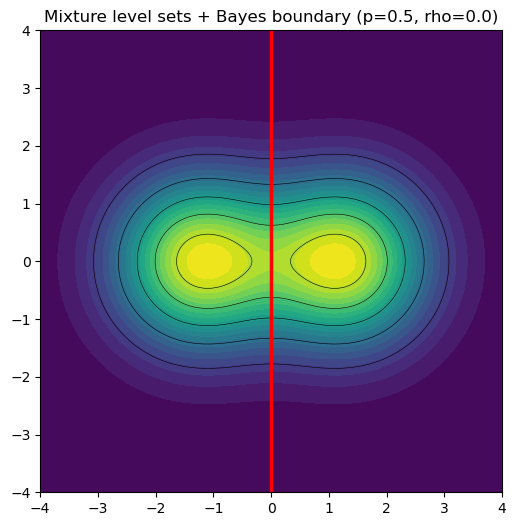

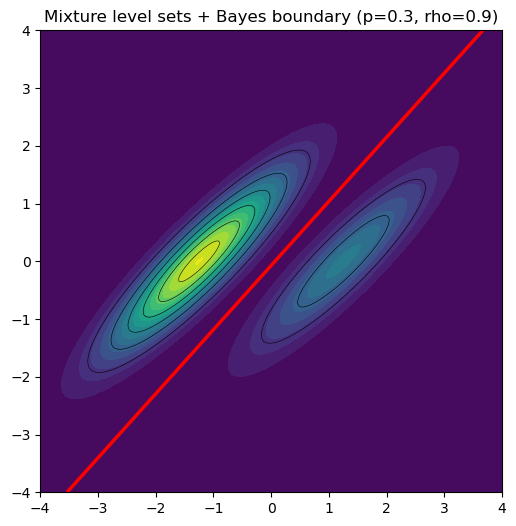

In [18]:
plot_mixture_and_bayes(
    p=0.5, 
    mu0=[-1.25, 0], 
    mu1=[+1.25, 0], 
    rho=0.0
)

# Now your turn, with unbalanced and correlated features
# Your code here
plot_mixture_and_bayes(
    p = 0.3, # not balance
    mu0=[-1.25, 0], 
    mu1=[+1.25, 0], 
    rho = 0.9 # correlated (Sigma is a non diagonal matrix)
)


Cela représente les densité de probabilité. On remarque que la frontière n'est pas centré entre les 2 ellipses car la probabilité n'est pas centrée. De plus les ellipses sont allongées due à une corrélation entre $\rho = 0.9$. Par contre cela reste une ligne droite car les matrices de covariances sont les mêmes, elle serait courbée si ce n'était pas le cas comment vu en TD. Le centre de ces ellipses sont les moyennes.

## 2. Generating Data From a Gaussian Mixture

We now generate labeled samples from  
$$
(1-p)\, \mathcal{ N(\mu_0, \Sigma)} \quad \text{and} \quad
p\, \mathcal {N(\mu_1, \Sigma)},
$$
and we will train classifiers on this data.

### Task
- Understand the `generate_mixture_samples` function.
- Generate datasets for multiple parameter choices.


In [19]:
def generate_mixture_samples(n, p, mu0, mu1, rho, random_state=None):
    """
    Generate n samples from the 2D Gaussian mixture:
        (1-p) N(mu0, Sigma) + p N(mu1, Sigma)
    with Sigma = [[1, rho], [rho, 1]].
    Returns X (n,2) and y (n,) in {0,1}.
    """
    rng = np.random.default_rng(random_state) 
    mu0, mu1 = np.asarray(mu0), np.asarray(mu1)
    Sigma = np.array([[1, rho], [rho, 1]])
    
    # sample class labels
    y = rng.binomial(1, p, size=n) # binomial law y = [0, 1, 1, 0, 1, 1, 0, 0, 0] for example
    
    # sample from multivariate normal according to classes
    X = np.zeros((n, 2))
    idx1 = (y == 1) # Boolean for class 1
    idx0 = ~idx1 # voolean for class 0
    
    if idx0.any():
        X[idx0] = multivariate_normal(mu0, Sigma).rvs(size=idx0.sum(), random_state=rng) # generation of class 0 points
    if idx1.any():
        X[idx1] = multivariate_normal(mu1, Sigma).rvs(size=idx1.sum(), random_state=rng) # feneration of class 1 points
    
    return X, y


### Visualizing the sampled dataset

We now generate 500 samples and visualize the resulting clusters.
This will serve as our training data for LDA and logistic regression later on.


In [20]:
p   = 0.5
mu0 = [-1.25, 0]
mu1 = [ 1.25, 0]
rho = 0.0

# Your code here
X, y = generate_mixture_samples(500, p, mu0, mu1, rho, random_state=42)



## 3. Linear Discriminant Analysis (LDA)

LDA is a **generative binary classifier** based on the assumption:

- both classes are Gaussian,
- with the **same covariance matrix** but different means.

Under these assumptions, the Bayes classifier is linear and can be estimated from data.

### Task
- Complete the LDA classifier below.
- Understand how `mu0`, `mu1`, and the shared covariance are estimated.


In [21]:
class LDAClassifier:
    def fit(self, X, y):
        X, y = np.asarray(X, float), np.asarray(y, int)
        
        X0, X1 = X[y == 0], X[y == 1]
        n0, n1 = len(X0), len(X1)
        self.p_ = n1 / (n0 + n1)
        
        # means
        self.mu0_, self.mu1_ =  X0.mean(axis=0), X1.mean(axis=0)# Your code here
        
        # pooled covariance = "means" of the two covariance because LDA supposed that covariance are the same
        S = ((n0 - 1) * np.cov(X0, rowvar=False) + (n1 - 1) * np.cov(X1, rowvar=False)) / (n0 + n1 - 2) # Your code here
        S_inv = np.linalg.inv(S)
        
        # linear discriminant parameters
        self.w_ = S_inv @ (self.mu1_ - self.mu0_)# Your code here
        t1 = self.mu1_ @ S_inv @ self.mu1_
        t0 = self.mu0_ @ S_inv @ self.mu0_
        self.b_ = 1/2 * (t0 - t1) + np.log(self.p_ / (1 - self.p_))# Your code here

        return self

    def decision_function(self, X):
        """Return the linear score w^T x + b."""
        # Your code here
        return X @ self.w_ + self.b_
        

    def predict_proba(self, X):
        # Your code here
        s = self.decision_function(X)
        p1 = sigmoid(s)
        return np.c_[1 - p1, p1]

    def predict(self, X):
        # Your code here
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

        


### Training and Evaluating LDA

We split the dataset into **training** and **test** sets.

### Task
- Train LDA using the training set.
- Evaluate prediction accuracy on the test set. 
- Print predicted probabilities for a few examples.
- Understand the structure of the predicted probabilities


In [25]:
# --- generate data from mixture ---
p   = 0.5
mu0 = [-1.25, 0]
mu1 = [ 1.25, 0]
rho = 0.3

X, y = generate_mixture_samples(500, p, mu0, mu1, rho, random_state=0)

# --- train/test split ---
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
)

# --- fit LDA ---
lda = LDAClassifier() # Your code here On crée l'object
lda.fit(X_train, y_train) 



# --- predict on first 5 test points ---
print("Test points:\n", X_test[:5])
print("True labels :", y_test[:5])
print("Predicted   :", lda.predict(X_test[:5]))
print("Predict proba:\n", lda.predict_proba(X_test[:5]))


Test points:
 [[ 1.14043505 -0.47432458]
 [-2.17615179  0.05386393]
 [-0.58474358  2.10801622]
 [ 1.58569423  0.68637463]
 [-1.88289474 -0.63697667]]
True labels : [1 0 0 1 0]
Predicted   : [1 0 0 1 0]
Predict proba:
 [[0.02070545 0.97929455]
 [0.99771265 0.00228735]
 [0.93269583 0.06730417]
 [0.01113035 0.98886965]
 [0.99209113 0.00790887]]


### Comparing LDA and Bayes Boundaries

Here we compare the decision boundaries:
- **LDA** (estimated from finite data)
- **Bayes** (the true optimal classifier)

### Question
- When do you expect LDA to match the Bayes classifier?   
  When n is huge, because empiracal estimation converge to the good value (loi des grands nombres)
- What happens when the sample size is small?   
  Empirical estimations are wrong. The line can move and it can create overfitting, it means that LDA adapts to noise


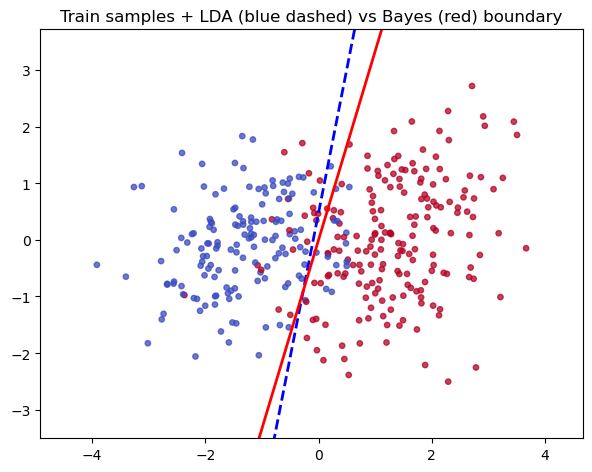

In [26]:
bayes = BayesClassifier(p, mu0, mu1, rho)

# --- grid (based on train set) ---
x_min, x_max = X_train[:,0].min()-1, X_train[:,0].max()+1
y_min, y_max = X_train[:,1].min()-1, X_train[:,1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
G = np.c_[xx.ravel(), yy.ravel()]

post_lda   = lda.predict_proba(G)[:,1].reshape(xx.shape)
post_bayes = bayes.predict_proba(G)[:,1].reshape(xx.shape)

# --- plot ---
plt.figure(figsize=(7,6))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, cmap="coolwarm",s=15, alpha=0.75)

# LDA boundary (blue)
plt.contour(xx, yy, post_lda, levels=[0.5], colors=["#0000ff"], linewidths=2, linestyles="--")
# Bayes boundary (bright red)
plt.contour(xx, yy, post_bayes, levels=[0.5], colors=["#ff0000"], linewidths=2)

plt.gca().set_aspect("equal")
plt.title("Train samples + LDA (blue dashed) vs Bayes (red) boundary")
plt.show()


Evaluate the accuracy of the LDA classifier on the test set

In [29]:
# LDA accuracy on test set
# Your code here
acc_lda = (lda.predict(X_test) == y_test).mean()
print(f"LDA accuracy on test set: {acc_lda:.4f}")

LDA accuracy on test set: 0.9000


### Double moons

We now use the double moons dataset, whose classes are clearly non-Gaussian.
Although LDA’s assumptions do not hold here, we can still train it and observe the resulting decision boundary and compare it with logistic regression.


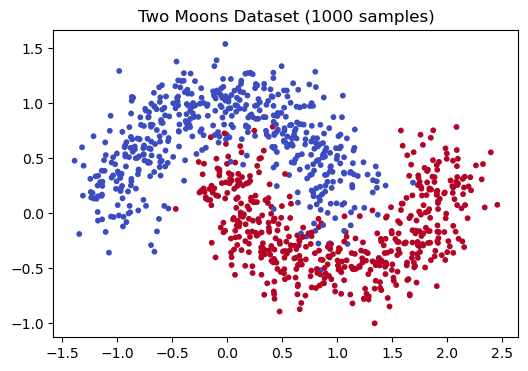

In [28]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

# generate data
X, y = make_moons(n_samples=1000, noise=0.2, random_state=0)

# scatter plot
plt.figure(figsize=(6,5))
plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", s=10)
plt.gca().set_aspect("equal")
plt.title("Two Moons Dataset (1000 samples)")
plt.show()


In [30]:
from sklearn.model_selection import train_test_split

# train / test split
# Your code here
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0
) 

# fit LDA
# Your code here
lda = LDAClassifier()
lda.fit(X_train, y_train)
# accuracy on test set
# Your code here
acc_lda = (lda.predict(X_test) == y_test).mean()
print(f"LDA accuracy on test set: {acc_lda:.4f}")


LDA accuracy on test set: 0.8333


Now let us visualize the decision boundary

In [31]:
def plot_points_and_boundary(clf, X, y, title="Decision boundary"):
    X, y = np.asarray(X), np.asarray(y)

    # grid around data
    x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
    y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 300),
        np.linspace(y_min, y_max, 300)
    )
    G = np.c_[xx.ravel(), yy.ravel()]

    # posterior for class 1 (assuming sklearn-style predict_proba)
    post = clf.predict_proba(G)[:,1].reshape(xx.shape)

    # plot
    plt.figure(figsize=(6,5))
    plt.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm",
                s=12, alpha=0.7)
    plt.contour(xx, yy, post, levels=[0.5], colors=["#0000ff"], linewidths=2)

    plt.gca().set_aspect("equal")
    plt.title(title)
    plt.show()


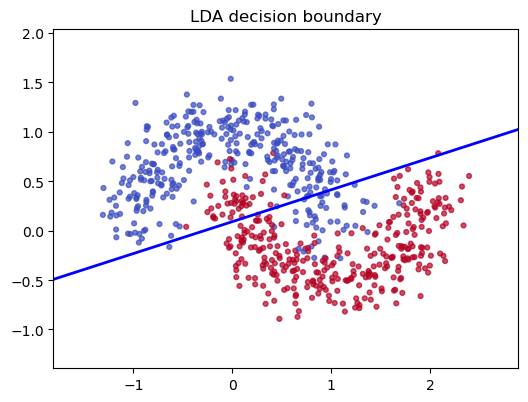

In [32]:
plot_points_and_boundary(lda, X_train, y_train, title="LDA decision boundary")


## 4. Logistic Regression

We now switch to a **discriminative** model: logistic regression.

### Objectives
- Fit a logistic classifier to the mixture data.
- Compare its decision boundary with LDA and Bayes.
- Explore improvements using **polynomial feature expansion**.


Logistic Regression accuracy on Two Moons test set: 0.8367


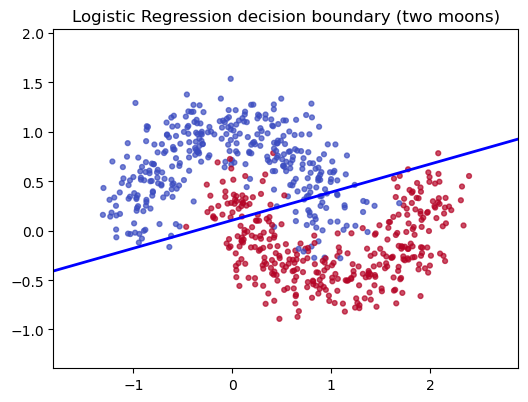

In [35]:
from sklearn.linear_model import LogisticRegression

# --- fit Logistic Regression ---
lr = LogisticRegression() # object # Your code here
lr.fit(X_train, y_train)
# --- accuracy ---
# Your code here
acc_lr = (lr.predict(X_test) == y_test).mean()
print(f"Logistic Regression accuracy on Two Moons test set: {acc_lr:.4f}")
# --- display decision boundary ---
plot_points_and_boundary(lr, X_train, y_train,
                         title="Logistic Regression decision boundary (two moons)")


Polynomial (degree 3) Logistic Regression accuracy on Two Moons test set: 0.9500


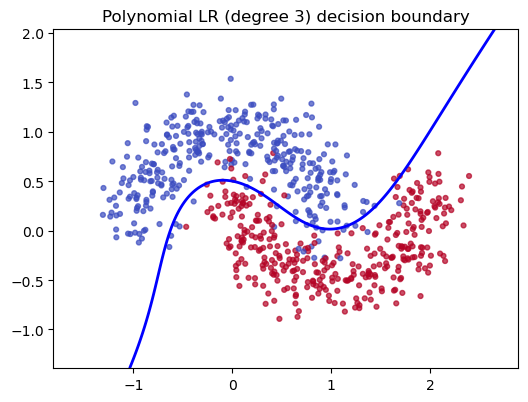

In [36]:
from sklearn.preprocessing import PolynomialFeatures

k = 3  # polynomial degree

# --- polynomial transform ---
poly = PolynomialFeatures(k, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly  = poly.transform(X_test)

# --- fit LR on polynomial features ---
lr_poly = LogisticRegression() # Your code here
lr_poly.fit(X_train_poly, y_train)
# --- accuracy ---
# Your code here
acc_lr_poly = (lr_poly.predict(X_test_poly) == y_test).mean()
print(f"Polynomial (degree {k}) Logistic Regression accuracy on Two Moons test set: {acc_lr_poly:.4f}")

# --- decision boundary plot (on original X grid) ---
# we wrap clf so plot_points_and_boundary can call predict_proba on raw X

class PolyWrapper:
    def __init__(self, poly, clf):
        self.poly = poly
        self.clf = clf
    def predict_proba(self, X):
        return self.clf.predict_proba(self.poly.transform(X))

plot_points_and_boundary(
    PolyWrapper(poly, lr_poly),
    X_train,
    y_train,
    title=f"Polynomial LR (degree {k}) decision boundary"
    
)


### Task: Increase the polynomial degree

Increase the value of \(k\) in the polynomial features and observe how the decision boundary evolves.  
To clearly see the effect **without regularization**, do **not** use the default scikit-learn setting.  
Instead, set: C = 1e9, so that regularization is essentially removed.  
Discuss what happens as \(k\) becomes large.

We are observing overfitting.

Polynomial degree 5: Accuracy = 0.9667


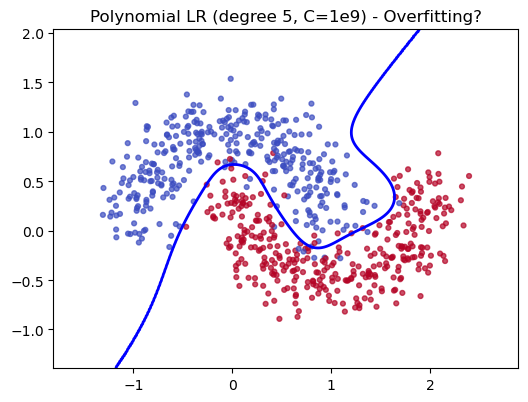

Polynomial degree 7: Accuracy = 0.9733


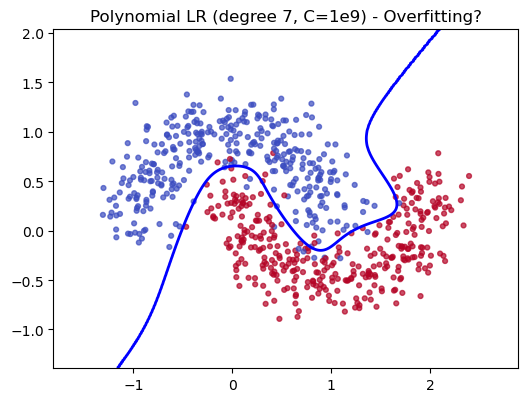

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Polynomial degree 18: Accuracy = 0.9633


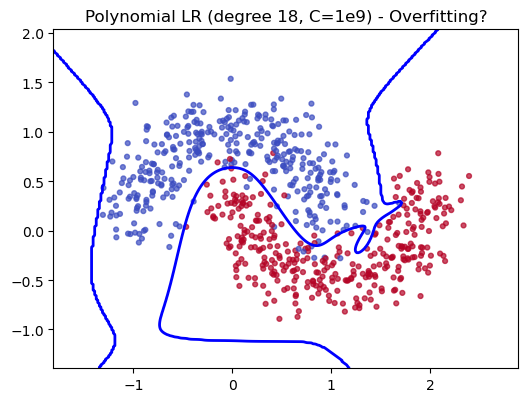

In [40]:
# Your code here
# Test avec plusieurs degrés polynomiaux
for k in [5, 7, 18]:
    # --- polynomial transform ---
    poly = PolynomialFeatures(k, include_bias=False)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)
    
    # --- fit LR WITHOUT regularization (C=1e9) ---
    lr_poly = LogisticRegression(C=1e9, max_iter=5000)
    lr_poly.fit(X_train_poly, y_train)
    
    # --- accuracy ---
    acc = (lr_poly.predict(X_test_poly) == y_test).mean()
    print(f"Polynomial degree {k}: Accuracy = {acc:.4f}")
    
    # --- plot decision boundary ---
    class PolyWrapper:
        def __init__(self, poly, clf):
            self.poly = poly
            self.clf = clf
        def predict_proba(self, X):
            return self.clf.predict_proba(self.poly.transform(X))
    
    plot_points_and_boundary(
        PolyWrapper(poly, lr_poly),
        X_train,
        y_train,
        title=f"Polynomial LR (degree {k}, C=1e9) - Overfitting?"
    )
    

## 5. ROC Curves and AUC

Accuracy alone is often insufficient.  
We now compare models using **ROC curves** and the **Area Under the Curve (AUC)**.

### Models compared:
- LDA
- Logistic regression
- Logistic regression with polynomial features (degree 3)

### Task
- Generate ROC curves for the three models.
- Compare their AUCs.
- Comment on which model is best and why.


AUC Scores:
  LDA                      : 0.9419
  Logistic Regression      : 0.9417
  Poly LR (degree 3)       : 0.9868


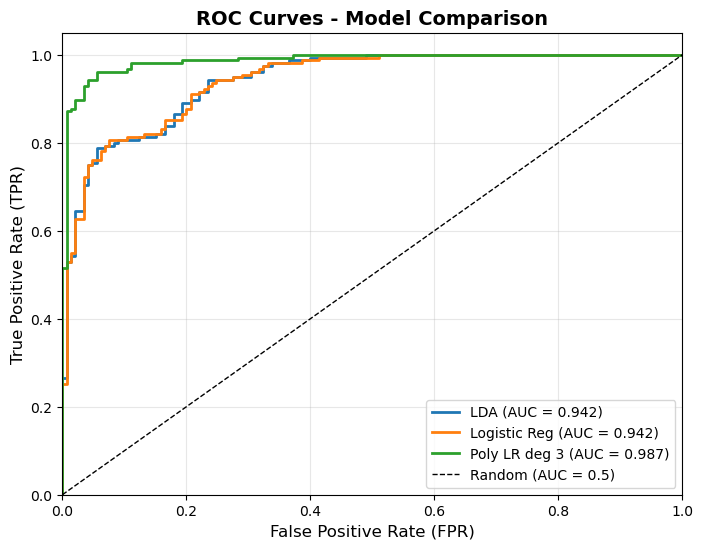

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

# Your code here

# 1. LDA 
lda = LDAClassifier()
lda.fit(X_train, y_train)

# 2. Logistic Regression 
lr = LogisticRegression()
lr.fit(X_train, y_train)

# 3. Logistic Regression avec features polynomiales (degré 3)
poly = PolynomialFeatures(3, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_poly = LogisticRegression()
lr_poly.fit(X_train_poly, y_train)

# --- Obtenir les probabilités prédites (pour la classe 1) ---
y_score_lda = lda.predict_proba(X_test)[:, 1]
y_score_lr = lr.predict_proba(X_test)[:, 1]
y_score_lr_poly = lr_poly.predict_proba(X_test_poly)[:, 1]

# --- Calculer les courbes ROC ---
fpr_lda, tpr_lda, _ = roc_curve(y_test, y_score_lda)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score_lr)
fpr_lr_poly, tpr_lr_poly, _ = roc_curve(y_test, y_score_lr_poly)

# --- Calculer les AUC ---
auc_lda = roc_auc_score(y_test, y_score_lda)
auc_lr = roc_auc_score(y_test, y_score_lr)
auc_lr_poly = roc_auc_score(y_test, y_score_lr_poly)

# --- Afficher les résultats ---
print("=" * 50)
print("AUC Scores:")
print(f"  LDA                      : {auc_lda:.4f}")
print(f"  Logistic Regression      : {auc_lr:.4f}")
print(f"  Poly LR (degree 3)       : {auc_lr_poly:.4f}")
print("=" * 50)

# --- Tracer les courbes ROC ---
plt.figure(figsize=(8, 6))

# Courbe LDA
plt.plot(fpr_lda, tpr_lda, linewidth=2, label=f'LDA (AUC = {auc_lda:.3f})')

# Courbe Logistic Regression
plt.plot(fpr_lr, tpr_lr, linewidth=2, label=f'Logistic Reg (AUC = {auc_lr:.3f})')

# Courbe Polynomial LR
plt.plot(fpr_lr_poly, tpr_lr_poly, linewidth=2, label=f'Poly LR deg 3 (AUC = {auc_lr_poly:.3f})')

# Ligne diagonale (classifieur aléatoire)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')

# Configuration du graphique
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()


## 6. Implementing Logistic Regression From Scratch

To deepen your understanding, you will build your own logistic regression class.

### Task
- Implement the gradient descent.


In [43]:
import numpy as np

class myLogisticRegression:
    def __init__(self, lr=0.1, max_iter=1000):
        self.lr = lr
        self.max_iter = max_iter
        self.loss_history = []       # <--- NEW

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    
    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n, d = X.shape

        # add intercept
        Xb = np.c_[np.ones(n), X]
        self.w = np.zeros(d + 1)

        for _ in range(self.max_iter):
            scores = Xb @ self.w # Your code here
            p1 = self.sigmoid(scores)

            # Binary cross-entropy loss
            loss = -np.mean(y * np.log(p1) + (1 - y) * np.log(1 - p1)) # Your code here
            self.loss_history.append(loss)

            # Gradient descent
            grad = Xb.T @ (p1 - y) / n # Your code here
            self.w -= self.lr * grad

        return self
    
    def predict_proba(self, X):
        Xb = np.c_[np.ones(len(X)), X]
        p1 = self.sigmoid(Xb @ self.w)
        return np.c_[1 - p1, p1]
    
    def predict(self, X):
        return (self.predict_proba(X)[:,1] >= 0.5).astype(int)


### Training Loss Curve

We now train our custom logistic model and visualize the **training loss**.

### Question
- Is the loss decreasing monotonically?
- What happens if you use a learning rate that’s too large? too small?


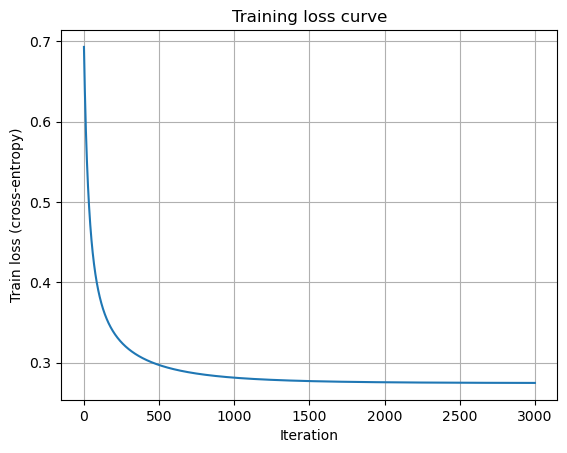

In [44]:
clf = myLogisticRegression(lr=0.1, max_iter=3000)
clf.fit(X_train, y_train)

import matplotlib.pyplot as plt
plt.plot(clf.loss_history)
plt.xlabel("Iteration")
plt.ylabel("Train loss (cross-entropy)")
plt.title("Training loss curve")
plt.grid(True)
plt.show()


Evaluate the accuracy

In [46]:
# Your code here
acc_my_lr = (clf.predict(X_test) == y_test).mean()
print(f"My Logistic Regression accuracy on Two Moons test set: {acc_my_lr:.4f}")    


My Logistic Regression accuracy on Two Moons test set: 0.8433
